## Experiments for binary treatment effect estimation comparison

In [2]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')

import CausalEGM as cegm
# import the module
from models import *

import numpy as np
import pickle
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


np.random.seed(42)
n_tr = 1000
n_p = 1000


## Twins

In [2]:
params = {"dataset": "Semi_Twins",
    "output_dir": './',
    "v_dim": 50,
    "z_dims": [1,1,1,7],
    "x_min": 0,
    "x_max": 3,
    "lr": 0.0002,
    "bs": 32,
    "alpha": 1,
    "beta": 1,
    "gamma": 10,
    "g_d_freq": 5,
    "g_units": [64,64,64,64,64],
    "e_units": [64,64,64,64,64],
    "f_units": [64,32,8],
    "h_units": [64,32,8],
    "dz_units": [64,32,8],
    "dv_units": [64,32,8],
    "binary_treatment": False,
    "use_z_rec": True,
    "use_v_gan": False,
    "save_res": False,
    "save_model": False,}
# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [3]:
# Number of repetitions
nrep = 10
n_tr = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Semi_Twins_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Semi_Twins_sampler(path = "../data_causl"
    ).load_all()
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400, tol=0)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=20000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 1.0676,	loss_y 0.3065, 0.3247, 0.0364,	loss_eta 0.7612, 0.8064, 0.0905
Epoch 400: loss 0.7389,	loss_y 0.1763, 0.3526, 0.3527,	loss_eta 0.5626, 1.1099, 1.0946
Epoch 800: loss 0.7076,	loss_y 0.1425, 0.2844, 0.2837,	loss_eta 0.5652, 1.1223, 1.1143
Epoch 1200: loss 0.7074,	loss_y 0.1387, 0.2758, 0.2742,	loss_eta 0.5687, 1.1262, 1.1150
Epoch 1600: loss 0.6978,	loss_y 0.1360, 0.2732, 0.2744,	loss_eta 0.5618, 1.1262, 1.1288
Epoch 2000: loss 0.7020,	loss_y 0.1343, 0.2685, 0.2686,	loss_eta 0.5678, 1.1261, 1.1166
Epoch 2400: loss 0.6904,	loss_y 0.1336, 0.2714, 0.2756,	loss_eta 0.5568, 1.1254, 1.1372
Epoch 2800: loss 0.6957,	loss_y 0.1344, 0.2658, 0.2628,	loss_eta 0.5613, 1.1154, 1.1082


2025-05-30 06:28:33.394076: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 06:28:33.394366: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.0935,	loss_y 0.3367, 0.3631, 0.0527,	loss_eta 0.7568, 0.7998, 0.0859
Epoch 400: loss 0.7680,	loss_y 0.2031, 0.4015, 0.3968,	loss_eta 0.5649, 1.1253, 1.1209
Epoch 800: loss 0.7002,	loss_y 0.1404, 0.2854, 0.2900,	loss_eta 0.5598, 1.1064, 1.0932
Epoch 1200: loss 0.7229,	loss_y 0.1373, 0.2754, 0.2762,	loss_eta 0.5855, 1.1430, 1.1150
Epoch 1600: loss 0.6924,	loss_y 0.1355, 0.2716, 0.2722,	loss_eta 0.5569, 1.1129, 1.1121
Epoch 2000: loss 0.6991,	loss_y 0.1333, 0.2700, 0.2733,	loss_eta 0.5658, 1.1246, 1.1176
Epoch 2400: loss 0.7080,	loss_y 0.1347, 0.2690, 0.2685,	loss_eta 0.5732, 1.1329, 1.1193
Epoch 2800: loss 0.6910,	loss_y 0.1311, 0.2616, 0.2610,	loss_eta 0.5599, 1.1191, 1.1184


2025-05-30 06:47:01.741099: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 06:47:01.741395: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.1280,	loss_y 0.3597, 0.3803, 0.0413,	loss_eta 0.7683, 0.8128, 0.0890
Epoch 400: loss 0.7852,	loss_y 0.2115, 0.4204, 0.4178,	loss_eta 0.5737, 1.1327, 1.1180
Epoch 800: loss 0.7070,	loss_y 0.1469, 0.2905, 0.2872,	loss_eta 0.5601, 1.1217, 1.1233
Epoch 1200: loss 0.6998,	loss_y 0.1389, 0.2780, 0.2783,	loss_eta 0.5609, 1.1293, 1.1368
Epoch 1600: loss 0.6949,	loss_y 0.1371, 0.2720, 0.2698,	loss_eta 0.5578, 1.1205, 1.1252
Epoch 2000: loss 0.6982,	loss_y 0.1346, 0.2702, 0.2711,	loss_eta 0.5636, 1.1179, 1.1084
Epoch 2400: loss 0.6941,	loss_y 0.1348, 0.2709, 0.2722,	loss_eta 0.5592, 1.1163, 1.1142
Epoch 2800: loss 0.7075,	loss_y 0.1337, 0.2695, 0.2717,	loss_eta 0.5738, 1.1272, 1.1069


2025-05-30 07:05:25.295005: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 07:05:25.295320: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.1218,	loss_y 0.3514, 0.3690, 0.0351,	loss_eta 0.7704, 0.7992, 0.0577
Epoch 400: loss 0.7650,	loss_y 0.1977, 0.3927, 0.3899,	loss_eta 0.5673, 1.1095, 1.0845
Epoch 800: loss 0.6922,	loss_y 0.1408, 0.2856, 0.2896,	loss_eta 0.5514, 1.1126, 1.1224
Epoch 1200: loss 0.7067,	loss_y 0.1396, 0.2780, 0.2768,	loss_eta 0.5671, 1.1266, 1.1189
Epoch 1600: loss 0.7003,	loss_y 0.1357, 0.2718, 0.2722,	loss_eta 0.5646, 1.1171, 1.1051
Epoch 2000: loss 0.7047,	loss_y 0.1372, 0.2723, 0.2701,	loss_eta 0.5675, 1.1274, 1.1198
Epoch 2400: loss 0.7006,	loss_y 0.1351, 0.2697, 0.2693,	loss_eta 0.5655, 1.1229, 1.1148
Epoch 2800: loss 0.6988,	loss_y 0.1329, 0.2691, 0.2724,	loss_eta 0.5659, 1.1246, 1.1174


2025-05-30 07:24:10.003570: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 07:24:10.003851: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.1223,	loss_y 0.3540, 0.3681, 0.0282,	loss_eta 0.7683, 0.7985, 0.0605
Epoch 400: loss 0.7649,	loss_y 0.2025, 0.4038, 0.4027,	loss_eta 0.5624, 1.1139, 1.1031
Epoch 800: loss 0.7129,	loss_y 0.1423, 0.2855, 0.2864,	loss_eta 0.5705, 1.1212, 1.1014
Epoch 1200: loss 0.6967,	loss_y 0.1374, 0.2776, 0.2804,	loss_eta 0.5593, 1.1274, 1.1362
Epoch 1600: loss 0.6894,	loss_y 0.1370, 0.2730, 0.2721,	loss_eta 0.5525, 1.1085, 1.1121
Epoch 2000: loss 0.6968,	loss_y 0.1359, 0.2727, 0.2738,	loss_eta 0.5609, 1.1213, 1.1208
Epoch 2400: loss 0.7025,	loss_y 0.1360, 0.2685, 0.2648,	loss_eta 0.5664, 1.1279, 1.1229
Epoch 2800: loss 0.6937,	loss_y 0.1336, 0.2658, 0.2645,	loss_eta 0.5601, 1.1160, 1.1118


2025-05-30 07:43:10.767756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 07:43:10.768058: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.1327,	loss_y 0.3487, 0.3568, 0.0164,	loss_eta 0.7840, 0.8146, 0.0611
Epoch 400: loss 0.7510,	loss_y 0.1872, 0.3737, 0.3730,	loss_eta 0.5638, 1.1097, 1.0918
Epoch 800: loss 0.7072,	loss_y 0.1445, 0.2865, 0.2840,	loss_eta 0.5627, 1.1259, 1.1263
Epoch 1200: loss 0.6976,	loss_y 0.1390, 0.2783, 0.2787,	loss_eta 0.5586, 1.1220, 1.1267
Epoch 1600: loss 0.7130,	loss_y 0.1361, 0.2733, 0.2745,	loss_eta 0.5769, 1.1480, 1.1422
Epoch 2000: loss 0.6964,	loss_y 0.1356, 0.2722, 0.2732,	loss_eta 0.5608, 1.1270, 1.1324
Epoch 2400: loss 0.7097,	loss_y 0.1331, 0.2657, 0.2652,	loss_eta 0.5766, 1.1375, 1.1218
Epoch 2800: loss 0.6970,	loss_y 0.1328, 0.2665, 0.2675,	loss_eta 0.5642, 1.1315, 1.1345


2025-05-30 08:02:11.445483: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 08:02:11.445770: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.0328,	loss_y 0.2807, 0.3460, 0.1306,	loss_eta 0.7521, 0.7923, 0.0805
Epoch 400: loss 0.7411,	loss_y 0.1821, 0.3745, 0.3847,	loss_eta 0.5590, 1.1106, 1.1032
Epoch 800: loss 0.6987,	loss_y 0.1413, 0.2841, 0.2854,	loss_eta 0.5574, 1.1219, 1.1290
Epoch 1200: loss 0.6975,	loss_y 0.1403, 0.2780, 0.2753,	loss_eta 0.5571, 1.1221, 1.1299
Epoch 1600: loss 0.7033,	loss_y 0.1367, 0.2707, 0.2680,	loss_eta 0.5666, 1.1234, 1.1137
Epoch 2000: loss 0.7029,	loss_y 0.1365, 0.2722, 0.2714,	loss_eta 0.5665, 1.1198, 1.1067
Epoch 2400: loss 0.6984,	loss_y 0.1337, 0.2671, 0.2670,	loss_eta 0.5647, 1.1192, 1.1090
Epoch 2800: loss 0.7080,	loss_y 0.1354, 0.2671, 0.2634,	loss_eta 0.5726, 1.1302, 1.1151


2025-05-30 08:22:15.498815: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 08:22:15.499133: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 1.0636,	loss_y 0.3027, 0.3293, 0.0532,	loss_eta 0.7609, 0.8022, 0.0827
Epoch 400: loss 0.7737,	loss_y 0.2077, 0.4126, 0.4098,	loss_eta 0.5660, 1.1246, 1.1173
Epoch 800: loss 0.7226,	loss_y 0.1440, 0.2925, 0.2970,	loss_eta 0.5787, 1.1330, 1.1086
Epoch 1200: loss 0.6983,	loss_y 0.1401, 0.2803, 0.2805,	loss_eta 0.5582, 1.1204, 1.1244
Epoch 1600: loss 0.7009,	loss_y 0.1382, 0.2761, 0.2758,	loss_eta 0.5627, 1.1261, 1.1268
Epoch 2000: loss 0.6984,	loss_y 0.1343, 0.2681, 0.2677,	loss_eta 0.5641, 1.1247, 1.1213
Epoch 2400: loss 0.7017,	loss_y 0.1337, 0.2682, 0.2689,	loss_eta 0.5679, 1.1299, 1.1239
Epoch 2800: loss 0.6931,	loss_y 0.1319, 0.2675, 0.2713,	loss_eta 0.5612, 1.1205, 1.1186


2025-05-30 08:43:07.305197: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 08:43:07.305506: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

: 

In [1]:
import os
import json
import numpy as np

# --- after you’ve computed these arrays --- #
# x_vals: array of dose levels, shape (n_doses,)
# fr_ci_lower, fr_mean_pred, fr_ci_upper: each shape (n_doses,)
# cegm_ci_lower, cegm_mean_pred, cegm_ci_upper: each shape (n_doses,)

# 1) build a results dict of pure Python types
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}

# 2) make sure the folder exists
output_dir = "result/continuous/increase_iter"
os.makedirs(output_dir, exist_ok=True)

# 3) write to JSON
outfile = os.path.join(output_dir, "twins.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


NameError: name 'x_vals' is not defined

## Hiran & Imbens

In [3]:

params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [4]:
# Number of repetitions
nrep = 5
n_tr = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Semi_Twins_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    mask = mask.flatten()  # Flatten to 1D if necessary
    x_tr = x_tr[mask]  # Apply mask to filter rows
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]

    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400, tol=0)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=20000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: loss 2.4989,	loss_y 1.7339, 1.7405, 0.0132,	loss_eta 0.7650, 0.8071, 0.0842
Epoch 400: loss 1.1748,	loss_y 0.6173, 0.9565, 0.6784,	loss_eta 0.5575, 1.1517, 1.1884
Epoch 800: loss 0.8177,	loss_y 0.2387, 0.4856, 0.4938,	loss_eta 0.5790, 1.2591, 1.3601
Epoch 1200: loss 0.6477,	loss_y 0.0750, 0.1459, 0.1417,	loss_eta 0.5727, 1.2359, 1.3264
Epoch 1600: loss 0.6164,	loss_y 0.0394, 0.0801, 0.0814,	loss_eta 0.5770, 1.1735, 1.1929
Epoch 2000: loss 0.6079,	loss_y 0.0279, 0.0542, 0.0527,	loss_eta 0.5800, 1.1634, 1.1668
Epoch 2400: loss 0.5959,	loss_y 0.0218, 0.0404, 0.0372,	loss_eta 0.5741, 1.1333, 1.1183
Epoch 2800: loss 0.6275,	loss_y 0.0178, 0.0327, 0.0300,	loss_eta 0.6097, 1.1481, 1.0766


2025-05-30 10:54:01.368884: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 10:54:01.369172: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.4001,	loss_y 1.6676, 1.6950, 0.0548,	loss_eta 0.7325, 0.7677, 0.0704
Epoch 400: loss 1.1489,	loss_y 0.5728, 1.0964, 1.0473,	loss_eta 0.5761, 1.1831, 1.2140
Epoch 800: loss 0.8176,	loss_y 0.2110, 0.4325, 0.4431,	loss_eta 0.6066, 1.2716, 1.3300
Epoch 1200: loss 0.6014,	loss_y 0.0582, 0.1407, 0.1651,	loss_eta 0.5432, 1.2071, 1.3278
Epoch 1600: loss 0.5498,	loss_y 0.0281, 0.0649, 0.0736,	loss_eta 0.5217, 1.1632, 1.2831
Epoch 2000: loss 0.5948,	loss_y 0.0210, 0.0497, 0.0574,	loss_eta 0.5738, 1.1599, 1.1721
Epoch 2400: loss 0.5976,	loss_y 0.0166, 0.0376, 0.0421,	loss_eta 0.5810, 1.1451, 1.1281
Epoch 2800: loss 0.5668,	loss_y 0.0126, 0.0329, 0.0405,	loss_eta 0.5542, 1.1134, 1.1184


2025-05-30 11:01:17.618366: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 11:01:17.618661: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3671,	loss_y 1.5901, 1.6079, 0.0356,	loss_eta 0.7770, 0.8147, 0.0754
Epoch 400: loss 1.0807,	loss_y 0.5529, 0.9099, 0.7142,	loss_eta 0.5279, 1.1771, 1.2986
Epoch 800: loss 0.7802,	loss_y 0.1899, 0.3614, 0.3430,	loss_eta 0.5903, 1.2479, 1.3152
Epoch 1200: loss 0.6431,	loss_y 0.0672, 0.1335, 0.1325,	loss_eta 0.5758, 1.2064, 1.2611
Epoch 1600: loss 0.6177,	loss_y 0.0327, 0.0716, 0.0777,	loss_eta 0.5849, 1.1772, 1.1845
Epoch 2000: loss 0.5989,	loss_y 0.0233, 0.0483, 0.0500,	loss_eta 0.5757, 1.1602, 1.1690
Epoch 2400: loss 0.5677,	loss_y 0.0181, 0.0404, 0.0447,	loss_eta 0.5497, 1.1292, 1.1591
Epoch 2800: loss 0.5961,	loss_y 0.0164, 0.0337, 0.0346,	loss_eta 0.5797, 1.1178, 1.0762


2025-05-30 11:08:42.947212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 11:08:42.947468: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.3083,	loss_y 1.5884, 1.6320, 0.0873,	loss_eta 0.7199, 0.7601, 0.0804
Epoch 400: loss 1.1486,	loss_y 0.5694, 1.1142, 1.0897,	loss_eta 0.5792, 1.1896, 1.2209
Epoch 800: loss 0.6906,	loss_y 0.1438, 0.2701, 0.2525,	loss_eta 0.5468, 1.2407, 1.3878
Epoch 1200: loss 0.6309,	loss_y 0.0422, 0.0882, 0.0921,	loss_eta 0.5887, 1.1993, 1.2210
Epoch 1600: loss 0.5402,	loss_y 0.0239, 0.0574, 0.0671,	loss_eta 0.5164, 1.1258, 1.2188
Epoch 2000: loss 0.5924,	loss_y 0.0183, 0.0414, 0.0462,	loss_eta 0.5741, 1.1395, 1.1308
Epoch 2400: loss 0.6020,	loss_y 0.0142, 0.0317, 0.0349,	loss_eta 0.5878, 1.1468, 1.1181
Epoch 2800: loss 0.5635,	loss_y 0.0127, 0.0275, 0.0295,	loss_eta 0.5508, 1.1207, 1.1399


2025-05-30 11:16:11.529494: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 11:16:11.529804: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 2.5273,	loss_y 1.7341, 1.7456, 0.0230,	loss_eta 0.7931, 0.8305, 0.0749
Epoch 400: loss 1.1195,	loss_y 0.5677, 0.9368, 0.7381,	loss_eta 0.5518, 1.1730, 1.2424
Epoch 800: loss 0.7333,	loss_y 0.1557, 0.3055, 0.2995,	loss_eta 0.5775, 1.2853, 1.4156
Epoch 1200: loss 0.6422,	loss_y 0.0605, 0.1152, 0.1095,	loss_eta 0.5817, 1.2356, 1.3078
Epoch 1600: loss 0.6239,	loss_y 0.0369, 0.0706, 0.0675,	loss_eta 0.5870, 1.1869, 1.1998
Epoch 2000: loss 0.6101,	loss_y 0.0247, 0.0491, 0.0488,	loss_eta 0.5854, 1.1588, 1.1468
Epoch 2400: loss 0.6036,	loss_y 0.0192, 0.0373, 0.0363,	loss_eta 0.5844, 1.1372, 1.1055
Epoch 2800: loss 0.5852,	loss_y 0.0135, 0.0305, 0.0340,	loss_eta 0.5717, 1.1136, 1.0838


2025-05-30 11:23:43.135997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-30 11:23:43.136258: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

KeyboardInterrupt: 

In [ ]:
import os
import json
import numpy as np

# --- after you’ve computed these arrays --- #
# x_vals: array of dose levels, shape (n_doses,)
# fr_ci_lower, fr_mean_pred, fr_ci_upper: each shape (n_doses,)
# cegm_ci_lower, cegm_mean_pred, cegm_ci_upper: each shape (n_doses,)

# 1) build a results dict of pure Python types
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}

# 2) make sure the folder exists
output_dir = "result/continuous/increase_iter"
os.makedirs(output_dir, exist_ok=True)

# 3) write to JSON
outfile = os.path.join(output_dir, "hiran.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/hiran.json


## Colangelo

In [8]:
params = {"dataset": "Sim_Colangelo",
"output_dir": './',
'v_dim': 100,
"z_dims": [5,5,5,5],
"x_min": -2,
"x_max": 2,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(-2, 2, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [9]:
from scipy.sparse import diags
from scipy.stats import norm
def Sim_Colangelo_sampler(N=20000, v_dim=100, seed=0,
                rho=0.5, offset = [-1,0,1], d=1, a=3, b=0.75):
    """Colangelo simulation dataset (continuous treatment) sampler (inherited from Base_sampler).

    Parameters
    ----------
    batch_size
        Int object denoting the batch size for mini-batch training. Default: ``32``.
    N
        Sample size. Default: ``20000``.
    v_dim
        Int object denoting the dimension for covariates. Default: ``200``.
    seed
        Int object denoting the random seed. Default: ``0``.
    Examples
    --------
    >>> from CausalEGM import Sim_Colangelo_sampler
    >>> ds = Sim_Colangelo_sampler(batch_size=32, N=20000, v_dim=100, seed=0)
    """

    np.random.seed(seed)
    k_list = [
        rho * np.ones(v_dim - 1),   # subdiagonal
        np.ones(v_dim),             # main diagonal
        rho * np.ones(v_dim - 1)    # superdiagonal
    ]
    offsets = [-1, 0, 1]
    sigma = diags(k_list, offsets).toarray()

    theta = np.array([(1/(l**2)) for l in list(range(1,(v_dim+1)))])
    epsilon = np.random.normal(0,1,N)
    nu = np.random.normal(0,1,N)
    v = np.random.multivariate_normal(np.zeros(v_dim),sigma,size=[N,])
    x = d*norm.cdf((a*v@theta)) + b*nu - 0.5
    y = 1.2*x + (x**3) + (x*v[:,0]) + 1.2*(v@theta) + epsilon
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    return x, y, v
    

In [10]:
# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 1000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Colangelo_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = Sim_Colangelo_sampler(
       N=n_tr, v_dim=100, seed=42+rep
    )
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    


    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=2000, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 3.6536,	loss_y 2.9210, 2.9410, 0.0400,	loss_eta 0.7327, 0.7756, 0.0858
Epoch 400: loss 1.7055,	loss_y 1.1276, 1.9500, 1.6448,	loss_eta 0.5779, 1.1875, 1.2191
Epoch 800: loss 0.9559,	loss_y 0.3820, 0.7009, 0.6377,	loss_eta 0.5739, 1.0795, 1.0113
Epoch 1200: loss 0.7249,	loss_y 0.1545, 0.2787, 0.2484,	loss_eta 0.5704, 1.0427, 0.9446
Epoch 1600: loss 0.6252,	loss_y 0.0759, 0.1314, 0.1109,	loss_eta 0.5493, 1.0484, 0.9983
Stopping at iter 1810: |Δy|=-9.3529e-03, |Δη|=-8.6656e-03


2025-05-28 14:59:59.633660: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 14:59:59.633942: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5854,	loss_y 2.8105, 2.8182, 0.0154,	loss_eta 0.7749, 0.8090, 0.0683
Epoch 400: loss 1.4217,	loss_y 0.8333, 1.5133, 1.3600,	loss_eta 0.5884, 1.2131, 1.2494
Stopping at iter 524: |Δy|=1.4482e-03, |Δη|=3.4881e-03


2025-05-28 15:00:35.816705: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:00:35.816985: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6492,	loss_y 2.8599, 2.8747, 0.0294,	loss_eta 0.7893, 0.8249, 0.0713
Epoch 400: loss 1.4280,	loss_y 0.8327, 1.5171, 1.3688,	loss_eta 0.5953, 1.1714, 1.1523
Epoch 800: loss 0.8804,	loss_y 0.2991, 0.5579, 0.5174,	loss_eta 0.5813, 1.0420, 0.9214
Epoch 1200: loss 0.6192,	loss_y 0.0878, 0.1737, 0.1718,	loss_eta 0.5314, 1.0091, 0.9554
Epoch 1600: loss 0.5805,	loss_y 0.0409, 0.0910, 0.1003,	loss_eta 0.5396, 1.0525, 1.0256
Stopping at iter 1644: |Δy|=4.5278e-03, |Δη|=1.5157e-03


2025-05-28 15:01:20.081342: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:01:20.081694: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6587,	loss_y 2.8789, 2.9039, 0.0499,	loss_eta 0.7798, 0.8194, 0.0792
Epoch 400: loss 1.4283,	loss_y 0.8616, 1.6881, 1.6530,	loss_eta 0.5667, 1.1709, 1.2085
Stopping at iter 443: |Δy|=7.6311e-03, |Δη|=5.2812e-03


2025-05-28 15:01:59.356485: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:01:59.356775: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6161,	loss_y 2.9176, 2.9578, 0.0805,	loss_eta 0.6985, 0.7375, 0.0780
Epoch 400: loss 1.6656,	loss_y 1.0915, 1.8929, 1.6027,	loss_eta 0.5741, 1.1929, 1.2377
Epoch 800: loss 0.9312,	loss_y 0.3740, 0.6501, 0.5521,	loss_eta 0.5571, 1.0677, 1.0210
Epoch 1200: loss 0.6676,	loss_y 0.1110, 0.2054, 0.1888,	loss_eta 0.5567, 1.0503, 0.9874
Stopping at iter 1499: |Δy|=7.4148e-03, |Δη|=3.0134e-03


2025-05-28 15:02:40.357750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:02:40.358025: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5364,	loss_y 2.8089, 2.8168, 0.0158,	loss_eta 0.7275, 0.7629, 0.0707
Epoch 400: loss 1.3538,	loss_y 0.7685, 1.5203, 1.5037,	loss_eta 0.5853, 1.1702, 1.1698
Stopping at iter 417: |Δy|=-9.8636e-03, |Δη|=7.3191e-03


2025-05-28 15:03:16.377539: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:03:16.377795: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5154,	loss_y 2.7560, 2.7862, 0.0604,	loss_eta 0.7594, 0.7983, 0.0778
Epoch 400: loss 1.4645,	loss_y 0.8832, 1.5586, 1.3507,	loss_eta 0.5813, 1.1794, 1.1964
Epoch 800: loss 0.8470,	loss_y 0.2632, 0.4691, 0.4118,	loss_eta 0.5838, 1.0665, 0.9654
Epoch 1200: loss 0.6459,	loss_y 0.0751, 0.1321, 0.1139,	loss_eta 0.5707, 1.0498, 0.9581
Stopping at iter 1434: |Δy|=-5.2495e-03, |Δη|=4.6831e-03


2025-05-28 15:03:57.549434: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:03:57.549718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5945,	loss_y 2.8404, 2.8634, 0.0461,	loss_eta 0.7541, 0.7950, 0.0819
Epoch 400: loss 1.4405,	loss_y 0.8847, 1.6521, 1.5348,	loss_eta 0.5558, 1.1797, 1.2478
Epoch 800: loss 0.8124,	loss_y 0.2603, 0.5014, 0.4822,	loss_eta 0.5521, 1.0531, 1.0020
Epoch 1200: loss 0.6403,	loss_y 0.0486, 0.1227, 0.1480,	loss_eta 0.5917, 1.0710, 0.9586
Epoch 1600: loss 0.6018,	loss_y 0.0192, 0.0545, 0.0707,	loss_eta 0.5826, 1.1197, 1.0742
Epoch 2000: loss 0.5798,	loss_y 0.0117, 0.0358, 0.0482,	loss_eta 0.5681, 1.1108, 1.0853


2025-05-28 15:04:40.102003: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:04:40.102296: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7056,	loss_y 2.9459, 2.9545, 0.0172,	loss_eta 0.7597, 0.8009, 0.0825
Epoch 400: loss 1.7050,	loss_y 1.1416, 1.9833, 1.6834,	loss_eta 0.5634, 1.2072, 1.2875
Stopping at iter 484: |Δy|=-4.5919e-04, |Δη|=-1.3448e-03


2025-05-28 15:05:16.459179: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:05:16.459466: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5374,	loss_y 2.7955, 2.8090, 0.0271,	loss_eta 0.7419, 0.7807, 0.0775
Epoch 400: loss 1.5803,	loss_y 1.0046, 1.7808, 1.5523,	loss_eta 0.5757, 1.1569, 1.1625
Epoch 800: loss 0.9109,	loss_y 0.3478, 0.6153, 0.5350,	loss_eta 0.5631, 1.0621, 0.9981
Epoch 1200: loss 0.6488,	loss_y 0.0555, 0.1334, 0.1557,	loss_eta 0.5933, 1.0726, 0.9586
Epoch 1600: loss 0.5851,	loss_y 0.0185, 0.0588, 0.0806,	loss_eta 0.5665, 1.0882, 1.0433
Epoch 2000: loss 0.5864,	loss_y 0.0126, 0.0399, 0.0548,	loss_eta 0.5738, 1.1088, 1.0700


2025-05-28 15:05:58.771000: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:05:58.771301: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4195,	loss_y 2.6787, 2.6931, 0.0287,	loss_eta 0.7408, 0.7740, 0.0665
Epoch 400: loss 1.3569,	loss_y 0.7626, 1.4447, 1.3643,	loss_eta 0.5943, 1.2017, 1.2147
Stopping at iter 531: |Δy|=-8.4999e-03, |Δη|=2.5282e-03


2025-05-28 15:06:34.967922: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:06:34.968227: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5252,	loss_y 2.7764, 2.7847, 0.0165,	loss_eta 0.7488, 0.7874, 0.0771
Epoch 400: loss 1.7932,	loss_y 1.2339, 2.1399, 1.8120,	loss_eta 0.5594, 1.2042, 1.2897
Stopping at iter 697: |Δy|=8.7446e-03, |Δη|=1.8421e-03


2025-05-28 15:07:11.857859: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:07:11.858154: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5574,	loss_y 2.7814, 2.7919, 0.0211,	loss_eta 0.7760, 0.8139, 0.0757
Epoch 400: loss 1.7974,	loss_y 1.1595, 2.0226, 1.7261,	loss_eta 0.6379, 1.2835, 1.2913
Epoch 800: loss 0.9603,	loss_y 0.3919, 0.7084, 0.6330,	loss_eta 0.5685, 1.0667, 0.9965
Epoch 1200: loss 0.7136,	loss_y 0.1217, 0.2209, 0.1984,	loss_eta 0.5920, 1.0607, 0.9375
Epoch 1600: loss 0.6010,	loss_y 0.0524, 0.0989, 0.0930,	loss_eta 0.5486, 1.0330, 0.9688
Stopping at iter 1737: |Δy|=-1.8232e-03, |Δη|=-5.8416e-03


2025-05-28 15:07:52.852926: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:07:52.853263: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6718,	loss_y 2.9148, 2.9372, 0.0447,	loss_eta 0.7569, 0.7985, 0.0832
Epoch 400: loss 1.8497,	loss_y 1.2881, 2.2089, 1.8417,	loss_eta 0.5617, 1.1576, 1.1919
Epoch 800: loss 1.4859,	loss_y 0.9344, 1.8259, 1.7830,	loss_eta 0.5514, 1.1501, 1.1974
Stopping at iter 834: |Δy|=-9.6617e-03, |Δη|=2.4669e-03


2025-05-28 15:08:30.024537: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:08:30.024833: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5053,	loss_y 2.7647, 2.7826, 0.0358,	loss_eta 0.7406, 0.7757, 0.0703
Epoch 400: loss 1.5516,	loss_y 0.9565, 1.7062, 1.4994,	loss_eta 0.5951, 1.2345, 1.2788
Stopping at iter 514: |Δy|=-3.2783e-05, |Δη|=3.1210e-03


2025-05-28 15:09:09.222314: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:09:09.222571: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5178,	loss_y 2.7785, 2.7938, 0.0305,	loss_eta 0.7393, 0.7738, 0.0689
Epoch 400: loss 1.3772,	loss_y 0.8066, 1.4723, 1.3314,	loss_eta 0.5706, 1.2088, 1.2764
Epoch 800: loss 0.8203,	loss_y 0.2606, 0.4390, 0.3567,	loss_eta 0.5596, 1.0835, 1.0476
Epoch 1200: loss 0.6616,	loss_y 0.0709, 0.1267, 0.1116,	loss_eta 0.5907, 1.0730, 0.9647
Stopping at iter 1323: |Δy|=-5.6824e-03, |Δη|=-2.3575e-03


2025-05-28 15:09:49.227596: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:09:49.227878: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6814,	loss_y 2.9165, 2.9405, 0.0480,	loss_eta 0.7649, 0.8023, 0.0749
Epoch 400: loss 1.5723,	loss_y 0.9850, 1.7506, 1.5312,	loss_eta 0.5873, 1.1712, 1.1679
Epoch 800: loss 0.8598,	loss_y 0.3109, 0.5396, 0.4574,	loss_eta 0.5489, 1.0421, 0.9864
Epoch 1200: loss 0.6720,	loss_y 0.0685, 0.1400, 0.1429,	loss_eta 0.6035, 1.0655, 0.9241
Epoch 1600: loss 0.5687,	loss_y 0.0223, 0.0588, 0.0731,	loss_eta 0.5464, 1.0559, 1.0190
Epoch 2000: loss 0.6028,	loss_y 0.0124, 0.0368, 0.0488,	loss_eta 0.5904, 1.1155, 1.0502


2025-05-28 15:10:30.785166: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:10:30.785461: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3787,	loss_y 2.6199, 2.6682, 0.0967,	loss_eta 0.7588, 0.8010, 0.0844
Epoch 400: loss 1.5670,	loss_y 1.0108, 1.8261, 1.6306,	loss_eta 0.5562, 1.1641, 1.2159
Stopping at iter 584: |Δy|=-2.8621e-03, |Δη|=-5.9218e-03


2025-05-28 15:11:06.868191: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:11:06.868501: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6814,	loss_y 2.8855, 2.9086, 0.0463,	loss_eta 0.7959, 0.8324, 0.0730
Epoch 400: loss 1.6867,	loss_y 1.1437, 1.9954, 1.7035,	loss_eta 0.5430, 1.1458, 1.2057
Stopping at iter 579: |Δy|=-5.8488e-03, |Δη|=9.6885e-03


2025-05-28 15:11:43.294059: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:11:43.294372: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4569,	loss_y 2.7007, 2.7129, 0.0244,	loss_eta 0.7562, 0.7931, 0.0739
Epoch 400: loss 1.5129,	loss_y 0.9161, 1.6580, 1.4838,	loss_eta 0.5968, 1.1831, 1.1727
Stopping at iter 531: |Δy|=-1.7791e-03, |Δη|=-9.0058e-03


2025-05-28 15:12:19.711993: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:12:19.712254: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7153,	loss_y 2.9551, 2.9746, 0.0391,	loss_eta 0.7602, 0.8005, 0.0805
Epoch 400: loss 1.7343,	loss_y 1.1299, 1.9364, 1.6132,	loss_eta 0.6045, 1.2463, 1.2836
Epoch 800: loss 0.8593,	loss_y 0.3252, 0.6246, 0.5987,	loss_eta 0.5341, 1.0402, 1.0122
Epoch 1200: loss 0.6908,	loss_y 0.0841, 0.1622, 0.1562,	loss_eta 0.6066, 1.0601, 0.9069
Epoch 1600: loss 0.6116,	loss_y 0.0381, 0.0815, 0.0868,	loss_eta 0.5735, 1.0735, 0.9999
Stopping at iter 1628: |Δy|=5.9041e-03, |Δη|=-4.8018e-03


2025-05-28 15:13:00.344253: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:13:00.344564: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7587,	loss_y 2.9679, 3.0018, 0.0679,	loss_eta 0.7909, 0.8312, 0.0806
Epoch 400: loss 1.4638,	loss_y 0.8944, 1.6889, 1.5890,	loss_eta 0.5694, 1.1826, 1.2264
Epoch 800: loss 0.8765,	loss_y 0.3028, 0.5681, 0.5306,	loss_eta 0.5737, 1.0669, 0.9865
Epoch 1200: loss 0.7015,	loss_y 0.1193, 0.2279, 0.2172,	loss_eta 0.5822, 1.0707, 0.9771
Stopping at iter 1452: |Δy|=-6.0449e-03, |Δη|=-3.6728e-03


2025-05-28 15:13:39.258377: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:13:39.258707: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5323,	loss_y 2.7575, 2.7699, 0.0249,	loss_eta 0.7749, 0.8137, 0.0777
Epoch 400: loss 1.6609,	loss_y 1.0499, 1.8509, 1.6020,	loss_eta 0.6110, 1.2348, 1.2476
Stopping at iter 462: |Δy|=-4.2615e-03, |Δη|=2.7205e-03


2025-05-28 15:14:14.726054: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:14:14.726378: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7259,	loss_y 2.9836, 3.0108, 0.0544,	loss_eta 0.7423, 0.7799, 0.0752
Epoch 400: loss 1.6573,	loss_y 1.0591, 1.8697, 1.6212,	loss_eta 0.5983, 1.1862, 1.1758
Epoch 800: loss 0.9667,	loss_y 0.3744, 0.6498, 0.5508,	loss_eta 0.5924, 1.0894, 0.9940
Epoch 1200: loss 0.6411,	loss_y 0.0962, 0.1663, 0.1403,	loss_eta 0.5449, 1.0209, 0.9520
Epoch 1600: loss 0.6581,	loss_y 0.0524, 0.0970, 0.0892,	loss_eta 0.6057, 1.0845, 0.9575
Stopping at iter 1628: |Δy|=-5.2828e-03, |Δη|=-5.7554e-04


2025-05-28 15:14:54.720094: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:14:54.720400: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7970,	loss_y 3.0825, 3.1103, 0.0556,	loss_eta 0.7145, 0.7530, 0.0770
Epoch 400: loss 1.4850,	loss_y 0.8465, 1.5201, 1.3470,	loss_eta 0.6384, 1.2681, 1.2594
Epoch 800: loss 0.8727,	loss_y 0.2788, 0.5024, 0.4471,	loss_eta 0.5939, 1.0766, 0.9653
Epoch 1200: loss 0.6487,	loss_y 0.0711, 0.1600, 0.1779,	loss_eta 0.5776, 1.0576, 0.9601
Epoch 1600: loss 0.6094,	loss_y 0.0347, 0.0930, 0.1166,	loss_eta 0.5747, 1.0768, 1.0043
Epoch 2000: loss 0.6091,	loss_y 0.0152, 0.0569, 0.0833,	loss_eta 0.5939, 1.1032, 1.0188


2025-05-28 15:15:35.877359: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:15:35.877683: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.8554,	loss_y 3.0537, 3.0626, 0.0177,	loss_eta 0.8017, 0.8312, 0.0591
Epoch 400: loss 1.7375,	loss_y 1.1427, 2.0440, 1.8025,	loss_eta 0.5948, 1.1917, 1.1937
Epoch 800: loss 0.9651,	loss_y 0.4405, 0.7981, 0.7152,	loss_eta 0.5247, 1.0631, 1.0769
Epoch 1200: loss 0.7046,	loss_y 0.1260, 0.1995, 0.1472,	loss_eta 0.5787, 1.0594, 0.9614
Epoch 1600: loss 0.6057,	loss_y 0.0558, 0.0972, 0.0829,	loss_eta 0.5499, 1.0509, 1.0020
Stopping at iter 1783: |Δy|=-7.8953e-03, |Δη|=-8.4035e-03


2025-05-28 15:16:15.648230: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:16:15.649157: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.8389,	loss_y 3.0417, 3.0524, 0.0214,	loss_eta 0.7972, 0.8381, 0.0819
Epoch 400: loss 1.5618,	loss_y 1.0047, 1.8317, 1.6539,	loss_eta 0.5571, 1.1390, 1.1639
Stopping at iter 443: |Δy|=-4.5288e-04, |Δη|=-3.6949e-03


2025-05-28 15:16:50.619238: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:16:50.619567: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7672,	loss_y 3.0023, 3.0162, 0.0278,	loss_eta 0.7649, 0.8068, 0.0839
Epoch 400: loss 1.6264,	loss_y 1.0474, 1.8359, 1.5771,	loss_eta 0.5790, 1.1820, 1.2061
Epoch 800: loss 0.9163,	loss_y 0.3598, 0.6217, 0.5238,	loss_eta 0.5565, 1.0621, 1.0113
Epoch 1200: loss 0.6867,	loss_y 0.1147, 0.2234, 0.2175,	loss_eta 0.5720, 1.0597, 0.9755
Stopping at iter 1456: |Δy|=-5.1183e-03, |Δη|=-1.2071e-03


2025-05-28 15:17:32.933337: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:17:32.933630: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4958,	loss_y 2.7462, 2.7551, 0.0178,	loss_eta 0.7496, 0.7880, 0.0767
Epoch 400: loss 1.6496,	loss_y 1.1030, 2.0237, 1.8413,	loss_eta 0.5466, 1.1694, 1.2457
Stopping at iter 585: |Δy|=-4.7541e-03, |Δη|=2.7745e-03


2025-05-28 15:18:09.225067: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:18:09.225404: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.6358,	loss_y 2.9014, 2.9103, 0.0178,	loss_eta 0.7344, 0.7749, 0.0810
Epoch 400: loss 1.6210,	loss_y 1.0431, 1.8669, 1.6477,	loss_eta 0.5780, 1.1972, 1.2385
Stopping at iter 462: |Δy|=-6.9413e-03, |Δη|=5.5147e-03


2025-05-28 15:18:44.798482: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 15:18:44.798800: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [11]:
import json
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}


output_dir = "result/continuous"
os.makedirs(output_dir, exist_ok=True)

outfile = os.path.join(output_dir, "colangelo.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/colangelo.json


## Sun

In [ ]:
params = {"dataset": "Sim_Sun",
"output_dir": './',
'v_dim': 200,
"z_dims": [2,2,2,4],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

In [ ]:
# Number of repetitions
nrep = 10
n_tr = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Sun_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data

    x_train, y_train, z_train = cegm.Sim_Sun_sampler(
        N=n_tr, v_dim=200, seed=42 + rep, batch_size=n_tr
    ).load_all()
    
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    mask = mask.flatten()  # Flatten to 1D if necessary
    x_tr = x_tr[mask]  # Apply mask to filter rows
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]

    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400,tol=0)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=30000, verbose=False)

    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 3.4723,	loss_y 2.7139, 2.7228, 0.0178,	loss_eta 0.7583, 0.7941, 0.0715
Epoch 400: loss 1.5300,	loss_y 0.9593, 1.4369, 0.9552,	loss_eta 0.5707, 1.3484, 1.5555
Epoch 800: loss 0.8847,	loss_y 0.2521, 0.5762, 0.6481,	loss_eta 0.6326, 1.4688, 1.6725
Epoch 1200: loss 0.6002,	loss_y 0.0758, 0.1787, 0.2058,	loss_eta 0.5244, 1.3998, 1.7507
Epoch 1600: loss 0.5837,	loss_y 0.0464, 0.1297, 0.1667,	loss_eta 0.5373, 1.3654, 1.6562
Epoch 2000: loss 0.6050,	loss_y 0.0309, 0.1047, 0.1475,	loss_eta 0.5741, 1.3343, 1.5204
Epoch 2400: loss 0.6084,	loss_y 0.0284, 0.0762, 0.0956,	loss_eta 0.5799, 1.3213, 1.4828
Epoch 2800: loss 0.6144,	loss_y 0.0221, 0.0671, 0.0899,	loss_eta 0.5923, 1.3048, 1.4250


2025-05-28 19:45:11.930411: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:45:11.930686: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5212,	loss_y 2.7402, 2.7654, 0.0505,	loss_eta 0.7810, 0.8153, 0.0686
Epoch 400: loss 1.3830,	loss_y 0.8105, 1.4759, 1.3310,	loss_eta 0.5726, 1.3302, 1.5152
Epoch 800: loss 0.7426,	loss_y 0.1914, 0.4022, 0.4216,	loss_eta 0.5512, 1.3650, 1.6277
Epoch 1200: loss 0.6804,	loss_y 0.0681, 0.1488, 0.1614,	loss_eta 0.6123, 1.3797, 1.5348
Epoch 1600: loss 0.6198,	loss_y 0.0464, 0.1002, 0.1076,	loss_eta 0.5735, 1.2913, 1.4357
Epoch 2000: loss 0.6253,	loss_y 0.0375, 0.0864, 0.0978,	loss_eta 0.5878, 1.2523, 1.3290
Epoch 2400: loss 0.5552,	loss_y 0.0362, 0.0774, 0.0823,	loss_eta 0.5190, 1.2220, 1.4060
Epoch 2800: loss 0.6314,	loss_y 0.0331, 0.0755, 0.0849,	loss_eta 0.5983, 1.2347, 1.2728


2025-05-28 19:45:49.467641: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:45:49.467931: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3505,	loss_y 2.6116, 2.6516, 0.0799,	loss_eta 0.7390, 0.7788, 0.0797
Epoch 400: loss 0.9903,	loss_y 0.4082, 0.9685, 1.1207,	loss_eta 0.5822, 1.2003, 1.2363
Epoch 800: loss 0.5553,	loss_y 0.0159, 0.0486, 0.0653,	loss_eta 0.5393, 1.1304, 1.1821
Epoch 1200: loss 0.5895,	loss_y 0.0104, 0.0257, 0.0307,	loss_eta 0.5791, 1.1874, 1.2165
Epoch 1600: loss 0.5677,	loss_y 0.0080, 0.0195, 0.0230,	loss_eta 0.5596, 1.1343, 1.1494
Epoch 2000: loss 0.5823,	loss_y 0.0074, 0.0186, 0.0225,	loss_eta 0.5750, 1.1358, 1.1217
Epoch 2400: loss 0.5744,	loss_y 0.0073, 0.0167, 0.0189,	loss_eta 0.5671, 1.1347, 1.1352
Epoch 2800: loss 0.5318,	loss_y 0.0064, 0.0156, 0.0184,	loss_eta 0.5254, 1.1040, 1.1571


2025-05-28 19:46:27.922857: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:46:27.923122: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7769,	loss_y 3.0298, 3.0475, 0.0354,	loss_eta 0.7470, 0.7878, 0.0816
Epoch 400: loss 0.9650,	loss_y 0.3487, 0.7726, 0.8479,	loss_eta 0.6163, 1.2918, 1.3511
Epoch 800: loss 0.5719,	loss_y 0.0191, 0.0429, 0.0476,	loss_eta 0.5528, 1.1660, 1.2264
Epoch 1200: loss 0.5830,	loss_y 0.0107, 0.0294, 0.0374,	loss_eta 0.5722, 1.1596, 1.1748
Epoch 1600: loss 0.5198,	loss_y 0.0096, 0.0246, 0.0302,	loss_eta 0.5102, 1.1515, 1.2826
Epoch 2000: loss 0.6249,	loss_y 0.0087, 0.0219, 0.0265,	loss_eta 0.6162, 1.2028, 1.1733
Epoch 2400: loss 0.5717,	loss_y 0.0076, 0.0196, 0.0240,	loss_eta 0.5641, 1.1820, 1.2358
Epoch 2800: loss 0.5827,	loss_y 0.0080, 0.0191, 0.0223,	loss_eta 0.5747, 1.1720, 1.1945


2025-05-28 19:47:06.217857: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:47:06.218143: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4595,	loss_y 2.7117, 2.7429, 0.0624,	loss_eta 0.7477, 0.7895, 0.0835
Epoch 400: loss 1.4154,	loss_y 0.8049, 1.4555, 1.3013,	loss_eta 0.6106, 1.3252, 1.4292
Epoch 800: loss 0.8149,	loss_y 0.1782, 0.4030, 0.4496,	loss_eta 0.6367, 1.3930, 1.5126
Epoch 1200: loss 0.7451,	loss_y 0.0908, 0.1649, 0.1481,	loss_eta 0.6542, 1.3503, 1.3921
Epoch 1600: loss 0.5926,	loss_y 0.0502, 0.1116, 0.1230,	loss_eta 0.5424, 1.2821, 1.4793
Epoch 2000: loss 0.6376,	loss_y 0.0413, 0.0881, 0.0936,	loss_eta 0.5963, 1.2939, 1.3951
Epoch 2400: loss 0.5953,	loss_y 0.0290, 0.0735, 0.0890,	loss_eta 0.5664, 1.2778, 1.4228
Epoch 2800: loss 0.6262,	loss_y 0.0254, 0.0615, 0.0722,	loss_eta 0.6008, 1.2825, 1.3635


2025-05-28 19:47:45.015842: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:47:45.016114: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5029,	loss_y 2.7316, 2.7492, 0.0354,	loss_eta 0.7713, 0.8067, 0.0707
Epoch 400: loss 1.3861,	loss_y 0.8364, 1.2404, 0.8081,	loss_eta 0.5497, 1.2421, 1.3847
Epoch 800: loss 0.6222,	loss_y 0.0385, 0.1067, 0.1363,	loss_eta 0.5836, 1.2201, 1.2729
Epoch 1200: loss 0.5932,	loss_y 0.0154, 0.0414, 0.0519,	loss_eta 0.5777, 1.1959, 1.2364
Epoch 1600: loss 0.5709,	loss_y 0.0104, 0.0289, 0.0371,	loss_eta 0.5605, 1.1785, 1.2360
Epoch 2000: loss 0.5304,	loss_y 0.0096, 0.0261, 0.0330,	loss_eta 0.5208, 1.1343, 1.2270
Epoch 2400: loss 0.5380,	loss_y 0.0082, 0.0222, 0.0280,	loss_eta 0.5297, 1.1382, 1.2169
Epoch 2800: loss 0.6512,	loss_y 0.0086, 0.0205, 0.0238,	loss_eta 0.6426, 1.2459, 1.2065


2025-05-28 19:48:23.375696: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:48:23.376009: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.1452,	loss_y 2.3765, 2.4167, 0.0805,	loss_eta 0.7687, 0.8108, 0.0842
Epoch 400: loss 1.5384,	loss_y 0.9923, 1.8049, 1.6252,	loss_eta 0.5461, 1.2399, 1.3876
Epoch 800: loss 0.7935,	loss_y 0.1763, 0.3937, 0.4346,	loss_eta 0.6172, 1.4261, 1.6178
Epoch 1200: loss 0.6366,	loss_y 0.0607, 0.1181, 0.1148,	loss_eta 0.5759, 1.3419, 1.5322
Epoch 1600: loss 0.6104,	loss_y 0.0449, 0.0961, 0.1025,	loss_eta 0.5655, 1.3059, 1.4807
Epoch 2000: loss 0.6327,	loss_y 0.0301, 0.0748, 0.0894,	loss_eta 0.6026, 1.2861, 1.3670
Epoch 2400: loss 0.6374,	loss_y 0.0254, 0.0685, 0.0862,	loss_eta 0.6120, 1.3003, 1.3766
Epoch 2800: loss 0.6518,	loss_y 0.0234, 0.0530, 0.0592,	loss_eta 0.6284, 1.2877, 1.3186


2025-05-28 19:49:01.883431: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:49:01.883718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4095,	loss_y 2.6716, 2.6918, 0.0403,	loss_eta 0.7379, 0.7778, 0.0799
Epoch 400: loss 1.7361,	loss_y 1.1701, 2.1460, 1.9517,	loss_eta 0.5659, 1.1568, 1.1817
Epoch 800: loss 0.8498,	loss_y 0.2114, 0.3941, 0.3655,	loss_eta 0.6384, 1.5155, 1.7541
Epoch 1200: loss 0.6662,	loss_y 0.0663, 0.1418, 0.1510,	loss_eta 0.5998, 1.3847, 1.5697
Epoch 1600: loss 0.6305,	loss_y 0.0422, 0.0895, 0.0945,	loss_eta 0.5882, 1.3090, 1.4415
Epoch 2000: loss 0.5997,	loss_y 0.0285, 0.0663, 0.0756,	loss_eta 0.5713, 1.2154, 1.2882
Epoch 2400: loss 0.5982,	loss_y 0.0278, 0.0591, 0.0626,	loss_eta 0.5703, 1.2010, 1.2614
Epoch 2800: loss 0.6386,	loss_y 0.0182, 0.0458, 0.0551,	loss_eta 0.6203, 1.2367, 1.2327


2025-05-28 19:49:40.338428: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:49:40.338752: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3628,	loss_y 2.5848, 2.6254, 0.0812,	loss_eta 0.7780, 0.8145, 0.0729
Epoch 400: loss 1.4368,	loss_y 0.8674, 1.4529, 1.1710,	loss_eta 0.5694, 1.4236, 1.7084
Epoch 800: loss 0.7585,	loss_y 0.1805, 0.3231, 0.2853,	loss_eta 0.5780, 1.5319, 1.9078
Epoch 1200: loss 0.7514,	loss_y 0.0981, 0.1650, 0.1337,	loss_eta 0.6533, 1.4255, 1.5445
Epoch 1600: loss 0.6976,	loss_y 0.0733, 0.1210, 0.0954,	loss_eta 0.6243, 1.3009, 1.3533
Epoch 2000: loss 0.6273,	loss_y 0.0498, 0.0882, 0.0769,	loss_eta 0.5776, 1.2342, 1.3134
Epoch 2400: loss 0.5966,	loss_y 0.0378, 0.0737, 0.0718,	loss_eta 0.5588, 1.2078, 1.2981
Epoch 2800: loss 0.6305,	loss_y 0.0280, 0.0611, 0.0663,	loss_eta 0.6025, 1.2203, 1.2356


2025-05-28 19:50:20.271492: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:50:20.271770: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3703,	loss_y 2.6133, 2.6463, 0.0661,	loss_eta 0.7571, 0.7918, 0.0694
Epoch 400: loss 1.3872,	loss_y 0.7780, 1.6031, 1.6502,	loss_eta 0.6092, 1.2678, 1.3171
Epoch 800: loss 0.7683,	loss_y 0.2034, 0.3931, 0.3795,	loss_eta 0.5649, 1.2169, 1.3040
Epoch 1200: loss 0.5924,	loss_y 0.0683, 0.1497, 0.1626,	loss_eta 0.5240, 1.1710, 1.2939
Epoch 1600: loss 0.5948,	loss_y 0.0407, 0.0890, 0.0965,	loss_eta 0.5541, 1.1953, 1.2825
Epoch 2000: loss 0.5184,	loss_y 0.0248, 0.0524, 0.0553,	loss_eta 0.4937, 1.1420, 1.2967
Epoch 2400: loss 0.5725,	loss_y 0.0202, 0.0517, 0.0629,	loss_eta 0.5523, 1.1978, 1.2909
Epoch 2800: loss 0.5621,	loss_y 0.0135, 0.0364, 0.0458,	loss_eta 0.5487, 1.2000, 1.3027


2025-05-28 19:50:58.519841: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:50:58.520120: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4159,	loss_y 2.6324, 2.6547, 0.0446,	loss_eta 0.7835, 0.8208, 0.0746
Epoch 400: loss 0.8991,	loss_y 0.3512, 0.7943, 0.8862,	loss_eta 0.5479, 1.1602, 1.2246
Epoch 800: loss 0.5601,	loss_y 0.0230, 0.0619, 0.0778,	loss_eta 0.5371, 1.1047, 1.1351
Epoch 1200: loss 0.5650,	loss_y 0.0109, 0.0334, 0.0450,	loss_eta 0.5542, 1.1292, 1.1500
Epoch 1600: loss 0.5652,	loss_y 0.0099, 0.0280, 0.0363,	loss_eta 0.5553, 1.1193, 1.1279
Epoch 2000: loss 0.5665,	loss_y 0.0075, 0.0208, 0.0266,	loss_eta 0.5590, 1.1419, 1.1659
Epoch 2400: loss 0.6095,	loss_y 0.0080, 0.0203, 0.0246,	loss_eta 0.6015, 1.1440, 1.0850
Epoch 2800: loss 0.5686,	loss_y 0.0075, 0.0173, 0.0197,	loss_eta 0.5611, 1.1234, 1.1246


2025-05-28 19:51:38.631510: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:51:38.631808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5026,	loss_y 2.7216, 2.7364, 0.0296,	loss_eta 0.7811, 0.8235, 0.0848
Epoch 400: loss 1.3532,	loss_y 0.7772, 1.5431, 1.5317,	loss_eta 0.5760, 1.2012, 1.2506
Epoch 800: loss 0.6327,	loss_y 0.0677, 0.1559, 0.1764,	loss_eta 0.5650, 1.1249, 1.1198
Epoch 1200: loss 0.5909,	loss_y 0.0149, 0.0368, 0.0438,	loss_eta 0.5760, 1.1687, 1.1854
Epoch 1600: loss 0.5818,	loss_y 0.0087, 0.0243, 0.0311,	loss_eta 0.5730, 1.1575, 1.1689
Epoch 2000: loss 0.5242,	loss_y 0.0088, 0.0219, 0.0261,	loss_eta 0.5154, 1.1326, 1.2344
Epoch 2400: loss 0.5572,	loss_y 0.0073, 0.0197, 0.0247,	loss_eta 0.5499, 1.1381, 1.1766
Epoch 2800: loss 0.5391,	loss_y 0.0074, 0.0170, 0.0192,	loss_eta 0.5317, 1.1210, 1.1785


2025-05-28 19:52:17.539914: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:52:17.540180: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4689,	loss_y 2.6997, 2.7455, 0.0914,	loss_eta 0.7692, 0.8056, 0.0729
Epoch 400: loss 1.4434,	loss_y 0.9173, 1.6903, 1.5459,	loss_eta 0.5261, 1.2279, 1.4036
Epoch 800: loss 0.7622,	loss_y 0.1434, 0.3577, 0.4286,	loss_eta 0.6188, 1.3939, 1.5501
Epoch 1200: loss 0.6135,	loss_y 0.0429, 0.1146, 0.1433,	loss_eta 0.5705, 1.3096, 1.4782
Epoch 1600: loss 0.6103,	loss_y 0.0263, 0.0732, 0.0938,	loss_eta 0.5839, 1.3448, 1.5218
Epoch 2000: loss 0.6440,	loss_y 0.0190, 0.0605, 0.0828,	loss_eta 0.6250, 1.3399, 1.4298
Epoch 2400: loss 0.6470,	loss_y 0.0197, 0.0500, 0.0605,	loss_eta 0.6273, 1.3276, 1.4007
Epoch 2800: loss 0.6484,	loss_y 0.0158, 0.0411, 0.0507,	loss_eta 0.6326, 1.3089, 1.3525


2025-05-28 19:52:56.770346: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:52:56.770680: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3094,	loss_y 2.5396, 2.5820, 0.0848,	loss_eta 0.7698, 0.8141, 0.0885
Epoch 400: loss 1.0664,	loss_y 0.4761, 1.1070, 1.2617,	loss_eta 0.5903, 1.2264, 1.2723
Epoch 800: loss 0.5837,	loss_y 0.0152, 0.0423, 0.0543,	loss_eta 0.5686, 1.1474, 1.1577
Epoch 1200: loss 0.6147,	loss_y 0.0113, 0.0301, 0.0377,	loss_eta 0.6034, 1.2017, 1.1967
Epoch 1600: loss 0.5225,	loss_y 0.0080, 0.0213, 0.0267,	loss_eta 0.5146, 1.1269, 1.2248
Epoch 2000: loss 0.5359,	loss_y 0.0079, 0.0195, 0.0232,	loss_eta 0.5280, 1.1494, 1.2429
Epoch 2400: loss 0.5881,	loss_y 0.0075, 0.0185, 0.0219,	loss_eta 0.5806, 1.1798, 1.1984
Epoch 2800: loss 0.5516,	loss_y 0.0079, 0.0174, 0.0191,	loss_eta 0.5437, 1.1412, 1.1951


2025-05-28 19:53:36.547893: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:53:36.548168: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2376,	loss_y 2.4504, 2.4595, 0.0182,	loss_eta 0.7872, 0.8242, 0.0740
Epoch 400: loss 1.2764,	loss_y 0.6677, 1.2660, 1.1966,	loss_eta 0.6086, 1.2677, 1.3181
Epoch 800: loss 0.6944,	loss_y 0.1193, 0.2251, 0.2115,	loss_eta 0.5751, 1.3063, 1.4624
Epoch 1200: loss 0.5951,	loss_y 0.0505, 0.0955, 0.0899,	loss_eta 0.5445, 1.2351, 1.3811
Epoch 1600: loss 0.6285,	loss_y 0.0339, 0.0636, 0.0593,	loss_eta 0.5946, 1.2782, 1.3673
Epoch 2000: loss 0.6427,	loss_y 0.0304, 0.0577, 0.0545,	loss_eta 0.6123, 1.2764, 1.3284
Epoch 2400: loss 0.5616,	loss_y 0.0235, 0.0476, 0.0481,	loss_eta 0.5381, 1.2117, 1.3473
Epoch 2800: loss 0.5830,	loss_y 0.0222, 0.0452, 0.0460,	loss_eta 0.5608, 1.2317, 1.3417


2025-05-28 19:54:16.046467: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:54:16.046761: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3759,	loss_y 2.6517, 2.6939, 0.0844,	loss_eta 0.7242, 0.7614, 0.0744
Epoch 400: loss 1.4117,	loss_y 0.8647, 1.5009, 1.2724,	loss_eta 0.5470, 1.3682, 1.6423
Epoch 800: loss 0.8455,	loss_y 0.2304, 0.4875, 0.5143,	loss_eta 0.6151, 1.4596, 1.6889
Epoch 1200: loss 0.6636,	loss_y 0.0772, 0.1419, 0.1294,	loss_eta 0.5864, 1.4555, 1.7383
Epoch 1600: loss 0.6307,	loss_y 0.0510, 0.1110, 0.1200,	loss_eta 0.5796, 1.4149, 1.6706
Epoch 2000: loss 0.6716,	loss_y 0.0391, 0.0832, 0.0882,	loss_eta 0.6324, 1.3845, 1.5042
Epoch 2400: loss 0.6050,	loss_y 0.0363, 0.0757, 0.0788,	loss_eta 0.5687, 1.2674, 1.3974
Epoch 2800: loss 0.5906,	loss_y 0.0317, 0.0692, 0.0751,	loss_eta 0.5589, 1.3054, 1.4929


2025-05-28 19:54:55.080217: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:54:55.080517: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.1567,	loss_y 2.3431, 2.3715, 0.0567,	loss_eta 0.8136, 0.8543, 0.0813
Epoch 400: loss 1.2548,	loss_y 0.6859, 1.3287, 1.2857,	loss_eta 0.5689, 1.2137, 1.2895
Epoch 800: loss 0.5929,	loss_y 0.0197, 0.0498, 0.0603,	loss_eta 0.5732, 1.1694, 1.1923
Epoch 1200: loss 0.5670,	loss_y 0.0114, 0.0321, 0.0413,	loss_eta 0.5555, 1.1573, 1.2036
Epoch 1600: loss 0.5220,	loss_y 0.0091, 0.0272, 0.0361,	loss_eta 0.5129, 1.1232, 1.2206
Epoch 2000: loss 0.5758,	loss_y 0.0089, 0.0224, 0.0271,	loss_eta 0.5669, 1.1509, 1.1680
Epoch 2400: loss 0.5900,	loss_y 0.0075, 0.0205, 0.0262,	loss_eta 0.5826, 1.1599, 1.1547
Epoch 2800: loss 0.5820,	loss_y 0.0081, 0.0191, 0.0220,	loss_eta 0.5739, 1.1694, 1.1912


2025-05-28 19:55:34.595637: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:55:34.595949: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5219,	loss_y 2.7899, 2.8121, 0.0445,	loss_eta 0.7320, 0.7704, 0.0767
Epoch 400: loss 1.6767,	loss_y 1.1109, 2.0159, 1.8100,	loss_eta 0.5658, 1.3217, 1.5118
Epoch 800: loss 0.8105,	loss_y 0.1767, 0.3162, 0.2789,	loss_eta 0.6338, 1.5807, 1.8939
Epoch 1200: loss 0.7152,	loss_y 0.0865, 0.1724, 0.1718,	loss_eta 0.6287, 1.4149, 1.5725
Epoch 1600: loss 0.6166,	loss_y 0.0601, 0.1142, 0.1082,	loss_eta 0.5565, 1.3119, 1.5107
Epoch 2000: loss 0.5561,	loss_y 0.0478, 0.0889, 0.0821,	loss_eta 0.5082, 1.1907, 1.3651
Epoch 2400: loss 0.6335,	loss_y 0.0290, 0.0608, 0.0636,	loss_eta 0.6045, 1.2382, 1.2672
Epoch 2800: loss 0.6532,	loss_y 0.0278, 0.0571, 0.0587,	loss_eta 0.6254, 1.2388, 1.2269


2025-05-28 19:56:13.320618: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:56:13.320928: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4051,	loss_y 2.6317, 2.6395, 0.0156,	loss_eta 0.7734, 0.8091, 0.0713
Epoch 400: loss 1.3793,	loss_y 0.8089, 1.4309, 1.2441,	loss_eta 0.5704, 1.3016, 1.4625
Epoch 800: loss 0.6989,	loss_y 0.1649, 0.3337, 0.3376,	loss_eta 0.5340, 1.2300, 1.3920
Epoch 1200: loss 0.6936,	loss_y 0.0580, 0.1437, 0.1712,	loss_eta 0.6356, 1.2895, 1.3078
Epoch 1600: loss 0.5325,	loss_y 0.0338, 0.0698, 0.0719,	loss_eta 0.4987, 1.1965, 1.3956
Epoch 2000: loss 0.5688,	loss_y 0.0204, 0.0513, 0.0617,	loss_eta 0.5484, 1.2284, 1.3600
Epoch 2400: loss 0.5935,	loss_y 0.0195, 0.0455, 0.0521,	loss_eta 0.5740, 1.2419, 1.3358
Epoch 2800: loss 0.5784,	loss_y 0.0157, 0.0379, 0.0444,	loss_eta 0.5628, 1.2478, 1.3700


2025-05-28 19:56:52.100341: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:56:52.100686: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3986,	loss_y 2.6190, 2.6296, 0.0210,	loss_eta 0.7796, 0.8209, 0.0827
Epoch 400: loss 1.2007,	loss_y 0.6799, 1.4664, 1.5730,	loss_eta 0.5208, 1.4065, 1.7714
Epoch 800: loss 0.7334,	loss_y 0.1323, 0.2319, 0.1994,	loss_eta 0.6012, 1.5120, 1.8217
Epoch 1200: loss 0.6849,	loss_y 0.0792, 0.1370, 0.1156,	loss_eta 0.6057, 1.3837, 1.5561
Epoch 1600: loss 0.5799,	loss_y 0.0565, 0.0948, 0.0766,	loss_eta 0.5234, 1.2240, 1.4013
Epoch 2000: loss 0.5929,	loss_y 0.0437, 0.0769, 0.0664,	loss_eta 0.5491, 1.2166, 1.3349
Epoch 2400: loss 0.6037,	loss_y 0.0360, 0.0648, 0.0576,	loss_eta 0.5677, 1.1885, 1.2415
Epoch 2800: loss 0.5941,	loss_y 0.0327, 0.0579, 0.0504,	loss_eta 0.5614, 1.1743, 1.2257


2025-05-28 19:57:31.502738: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:57:31.503062: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3772,	loss_y 2.6113, 2.6261, 0.0295,	loss_eta 0.7659, 0.8014, 0.0710
Epoch 400: loss 1.3782,	loss_y 0.7861, 1.4674, 1.3626,	loss_eta 0.5922, 1.3762, 1.5681
Epoch 800: loss 0.7777,	loss_y 0.1328, 0.2458, 0.2260,	loss_eta 0.6450, 1.4677, 1.6455
Epoch 1200: loss 0.6514,	loss_y 0.0790, 0.1503, 0.1425,	loss_eta 0.5724, 1.2936, 1.4424
Epoch 1600: loss 0.6077,	loss_y 0.0634, 0.1150, 0.1032,	loss_eta 0.5443, 1.2178, 1.3469
Epoch 2000: loss 0.5690,	loss_y 0.0501, 0.0986, 0.0970,	loss_eta 0.5189, 1.1878, 1.3378
Epoch 2400: loss 0.6366,	loss_y 0.0397, 0.0791, 0.0787,	loss_eta 0.5969, 1.2026, 1.2114
Epoch 2800: loss 0.6397,	loss_y 0.0356, 0.0679, 0.0647,	loss_eta 0.6041, 1.1879, 1.1675


2025-05-28 19:58:09.706268: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:58:09.706537: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.2684,	loss_y 2.5066, 2.5256, 0.0380,	loss_eta 0.7618, 0.8004, 0.0771
Epoch 400: loss 1.3064,	loss_y 0.6920, 1.4610, 1.5380,	loss_eta 0.6145, 1.2427, 1.2565
Epoch 800: loss 0.6065,	loss_y 0.0376, 0.0939, 0.1124,	loss_eta 0.5689, 1.1699, 1.2021
Epoch 1200: loss 0.6321,	loss_y 0.0125, 0.0313, 0.0375,	loss_eta 0.6196, 1.2302, 1.2213
Epoch 1600: loss 0.5214,	loss_y 0.0108, 0.0252, 0.0288,	loss_eta 0.5106, 1.0717, 1.1222
Epoch 2000: loss 0.5067,	loss_y 0.0084, 0.0214, 0.0260,	loss_eta 0.4983, 1.1178, 1.2389
Epoch 2400: loss 0.5654,	loss_y 0.0071, 0.0192, 0.0242,	loss_eta 0.5583, 1.1622, 1.2077
Epoch 2800: loss 0.5779,	loss_y 0.0074, 0.0190, 0.0231,	loss_eta 0.5704, 1.1671, 1.1934


2025-05-28 19:58:47.725723: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:58:47.726016: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.5899,	loss_y 2.7753, 2.7898, 0.0289,	loss_eta 0.8145, 0.8516, 0.0741
Epoch 400: loss 1.1870,	loss_y 0.6287, 1.1220, 0.9866,	loss_eta 0.5583, 1.2591, 1.4015
Epoch 800: loss 0.5672,	loss_y 0.0281, 0.0804, 0.1047,	loss_eta 0.5392, 1.1608, 1.2432
Epoch 1200: loss 0.5513,	loss_y 0.0119, 0.0403, 0.0569,	loss_eta 0.5394, 1.1297, 1.1806
Epoch 1600: loss 0.5757,	loss_y 0.0112, 0.0303, 0.0381,	loss_eta 0.5645, 1.1593, 1.1896
Epoch 2000: loss 0.6173,	loss_y 0.0090, 0.0276, 0.0371,	loss_eta 0.6083, 1.2028, 1.1891
Epoch 2400: loss 0.5971,	loss_y 0.0083, 0.0247, 0.0329,	loss_eta 0.5889, 1.1958, 1.2138
Epoch 2800: loss 0.6022,	loss_y 0.0084, 0.0212, 0.0255,	loss_eta 0.5938, 1.1839, 1.1802


2025-05-28 19:59:25.595661: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 19:59:25.595984: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3423,	loss_y 2.5645, 2.5810, 0.0329,	loss_eta 0.7777, 0.8146, 0.0737
Epoch 400: loss 1.5101,	loss_y 0.9364, 1.4356, 0.9984,	loss_eta 0.5737, 1.3969, 1.6463
Epoch 800: loss 0.8335,	loss_y 0.2062, 0.3568, 0.3011,	loss_eta 0.6273, 1.5697, 1.8848
Epoch 1200: loss 0.6750,	loss_y 0.0989, 0.1680, 0.1381,	loss_eta 0.5761, 1.4028, 1.6535
Epoch 1600: loss 0.6849,	loss_y 0.0669, 0.1226, 0.1115,	loss_eta 0.6180, 1.2888, 1.3415
Epoch 2000: loss 0.6245,	loss_y 0.0493, 0.0943, 0.0900,	loss_eta 0.5752, 1.2232, 1.2961
Epoch 2400: loss 0.6307,	loss_y 0.0415, 0.0864, 0.0898,	loss_eta 0.5892, 1.2532, 1.3280
Epoch 2800: loss 0.6110,	loss_y 0.0350, 0.0686, 0.0672,	loss_eta 0.5760, 1.1876, 1.2231


2025-05-28 20:00:04.292439: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:00:04.292738: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3438,	loss_y 2.5093, 2.5202, 0.0218,	loss_eta 0.8346, 0.8718, 0.0745
Epoch 400: loss 1.2214,	loss_y 0.6239, 1.3587, 1.4696,	loss_eta 0.5975, 1.2496, 1.3042
Epoch 800: loss 0.6528,	loss_y 0.0238, 0.0802, 0.1128,	loss_eta 0.6290, 1.2036, 1.1492
Epoch 1200: loss 0.6361,	loss_y 0.0114, 0.0358, 0.0489,	loss_eta 0.6248, 1.1812, 1.1129
Epoch 1600: loss 0.5559,	loss_y 0.0100, 0.0257, 0.0315,	loss_eta 0.5459, 1.1168, 1.1418
Epoch 2000: loss 0.5919,	loss_y 0.0075, 0.0204, 0.0258,	loss_eta 0.5844, 1.1617, 1.1545
Epoch 2400: loss 0.5158,	loss_y 0.0081, 0.0177, 0.0191,	loss_eta 0.5077, 1.0868, 1.1582
Epoch 2800: loss 0.5857,	loss_y 0.0073, 0.0171, 0.0195,	loss_eta 0.5784, 1.1576, 1.1584


2025-05-28 20:00:42.725644: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:00:42.725937: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.4723,	loss_y 2.7265, 2.7352, 0.0174,	loss_eta 0.7458, 0.7873, 0.0829
Epoch 400: loss 1.3982,	loss_y 0.7807, 1.3341, 1.1068,	loss_eta 0.6175, 1.4567, 1.6786
Epoch 800: loss 0.7999,	loss_y 0.1939, 0.3355, 0.2832,	loss_eta 0.6060, 1.4871, 1.7621
Epoch 1200: loss 0.7168,	loss_y 0.0844, 0.1642, 0.1596,	loss_eta 0.6323, 1.4177, 1.5708
Epoch 1600: loss 0.6577,	loss_y 0.0546, 0.1144, 0.1196,	loss_eta 0.6032, 1.3349, 1.4635
Epoch 2000: loss 0.6095,	loss_y 0.0412, 0.0868, 0.0912,	loss_eta 0.5683, 1.2980, 1.4593
Epoch 2400: loss 0.6022,	loss_y 0.0371, 0.0772, 0.0802,	loss_eta 0.5650, 1.2053, 1.2806
Epoch 2800: loss 0.5538,	loss_y 0.0318, 0.0683, 0.0730,	loss_eta 0.5221, 1.1665, 1.2888


 87%|████████▋ | 26/30 [16:45<02:30, 37.52s/it]

Epoch 1: loss 3.4820,	loss_y 2.7291, 2.7451, 0.0321,	loss_eta 0.7529, 0.7915, 0.0771
Epoch 400: loss 1.5233,	loss_y 0.8680, 1.6568, 1.5775,	loss_eta 0.6553, 1.3133, 1.3161
Epoch 800: loss 0.6406,	loss_y 0.0848, 0.1821, 0.1946,	loss_eta 0.5557, 1.1562, 1.2009
Epoch 1200: loss 0.5779,	loss_y 0.0164, 0.0447, 0.0566,	loss_eta 0.5615, 1.1266, 1.1302
Epoch 1600: loss 0.5930,	loss_y 0.0101, 0.0280, 0.0358,	loss_eta 0.5829, 1.1616, 1.1575
Epoch 2000: loss 0.5381,	loss_y 0.0082, 0.0237, 0.0310,	loss_eta 0.5299, 1.1321, 1.2045
Epoch 2400: loss 0.5924,	loss_y 0.0078, 0.0195, 0.0235,	loss_eta 0.5846, 1.1369, 1.1045
Epoch 2800: loss 0.5939,	loss_y 0.0089, 0.0195, 0.0211,	loss_eta 0.5850, 1.1703, 1.1707


2025-05-28 20:01:56.069314: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:01:56.069595: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.7080,	loss_y 2.9440, 2.9580, 0.0280,	loss_eta 0.7640, 0.8029, 0.0777
Epoch 400: loss 1.4570,	loss_y 0.8436, 1.6183, 1.5494,	loss_eta 0.6134, 1.4477, 1.6686
Epoch 800: loss 0.7152,	loss_y 0.1223, 0.2914, 0.3383,	loss_eta 0.5929, 1.5795, 1.9731
Epoch 1200: loss 0.6714,	loss_y 0.0575, 0.1266, 0.1381,	loss_eta 0.6139, 1.4229, 1.6180
Epoch 1600: loss 0.5888,	loss_y 0.0357, 0.1056, 0.1398,	loss_eta 0.5531, 1.3484, 1.5906
Epoch 2000: loss 0.6214,	loss_y 0.0261, 0.0822, 0.1122,	loss_eta 0.5953, 1.2926, 1.3947
Epoch 2400: loss 0.6710,	loss_y 0.0246, 0.0665, 0.0838,	loss_eta 0.6463, 1.3118, 1.3309
Epoch 2800: loss 0.6336,	loss_y 0.0210, 0.0547, 0.0673,	loss_eta 0.6126, 1.2459, 1.2666


2025-05-28 20:02:34.071471: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:02:34.071739: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.3169,	loss_y 2.5797, 2.6327, 0.1060,	loss_eta 0.7372, 0.7794, 0.0844
Epoch 400: loss 1.2098,	loss_y 0.6722, 1.4292, 1.5139,	loss_eta 0.5376, 1.2005, 1.3259
Epoch 800: loss 0.5740,	loss_y 0.0273, 0.0756, 0.0966,	loss_eta 0.5466, 1.1490, 1.2048
Epoch 1200: loss 0.5819,	loss_y 0.0120, 0.0351, 0.0462,	loss_eta 0.5700, 1.1715, 1.2031
Epoch 1600: loss 0.5679,	loss_y 0.0090, 0.0250, 0.0319,	loss_eta 0.5588, 1.1363, 1.1549
Epoch 2000: loss 0.6333,	loss_y 0.0095, 0.0238, 0.0285,	loss_eta 0.6238, 1.1927, 1.1378
Epoch 2400: loss 0.5779,	loss_y 0.0085, 0.0198, 0.0226,	loss_eta 0.5694, 1.1208, 1.1029
Epoch 2800: loss 0.5824,	loss_y 0.0076, 0.0188, 0.0225,	loss_eta 0.5748, 1.1650, 1.1803


2025-05-28 20:03:12.938519: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:03:12.938807: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 3.1986,	loss_y 2.4694, 2.4776, 0.0163,	loss_eta 0.7291, 0.7699, 0.0815
Epoch 400: loss 1.4581,	loss_y 0.9311, 1.6834, 1.5047,	loss_eta 0.5270, 1.3509, 1.6478
Epoch 800: loss 0.7014,	loss_y 0.1163, 0.2201, 0.2076,	loss_eta 0.5851, 1.4755, 1.7808
Epoch 1200: loss 0.6110,	loss_y 0.0672, 0.1469, 0.1594,	loss_eta 0.5438, 1.3214, 1.5551
Epoch 1600: loss 0.6125,	loss_y 0.0440, 0.0907, 0.0934,	loss_eta 0.5685, 1.2455, 1.3540
Epoch 2000: loss 0.6164,	loss_y 0.0369, 0.0804, 0.0870,	loss_eta 0.5794, 1.2319, 1.3049
Epoch 2400: loss 0.6003,	loss_y 0.0300, 0.0720, 0.0840,	loss_eta 0.5703, 1.1883, 1.2360
Epoch 2800: loss 0.5181,	loss_y 0.0283, 0.0599, 0.0633,	loss_eta 0.4898, 1.1299, 1.2803


2025-05-28 20:03:50.699010: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-28 20:03:50.699335: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [ ]:
import json
summary = {
    "x_vals": x_vals.tolist(),
    "Frengression": {
        "ci_lower": fr_ci_lower.tolist(),
        "mean":     fr_mean_pred.tolist(),
        "ci_upper": fr_ci_upper.tolist()
    },
    "CausalEGM": {
        "ci_lower": cegm_ci_lower.tolist(),
        "mean":     cegm_mean_pred.tolist(),
        "ci_upper": cegm_ci_upper.tolist()
    }
}


output_dir = "result/continuous/increase_iter"
os.makedirs(output_dir, exist_ok=True)

outfile = os.path.join(output_dir, "sun.json")
with open(outfile, "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved ADRF summary to {outfile}")


Saved ADRF summary to result/continuous/sun.json


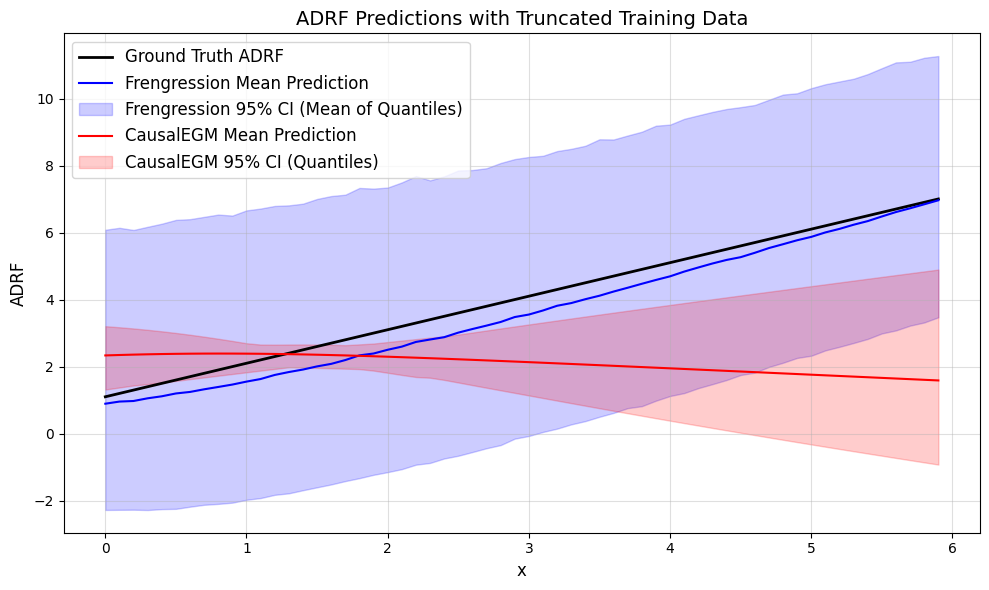

Frengression Average RMSE: 0.7700
CausalEGM Average RMSE: 2.7950


In [5]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI (Mean of Quantiles)')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI (Quantiles)')

# Add title, labels, and legend
plt.title('ADRF Predictions with Truncated Training Data', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('ADRF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()

# Compute and print average RMSEs
fr_rmses = [rmse(fr_preds[1][:, rep], ground_truth_adrf) for rep in range(nrep)]
cegm_rmses = [rmse(cegm_preds[:, rep], ground_truth_adrf) for rep in range(nrep)]

print(f"Frengression Average RMSE: {np.mean(fr_rmses):.4f}")
print(f"CausalEGM Average RMSE: {np.mean(cegm_rmses):.4f}")

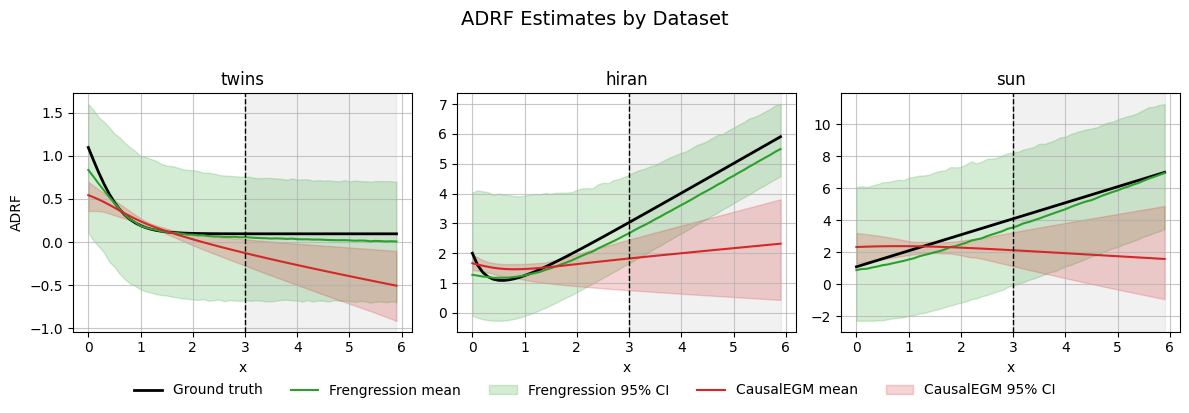

twins: Frengression RMSE = 0.0683, CausalEGM RMSE = 0.3288
twins: Frengression MAPE = 0.4262, CausalEGM MAPE = 0.4262
hiran: Frengression RMSE = 0.3318, CausalEGM RMSE = 1.8003
hiran: Frengression MAPE = 0.0948, CausalEGM MAPE = 0.0948
sun: Frengression RMSE = 0.4459, CausalEGM RMSE = 2.7905
sun: Frengression MAPE = 0.1373, CausalEGM MAPE = 0.1373


In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1) Configuration
dataset_names = ["twins", "hiran", "sun"]   # removed "colangelo"
output_dir    = "result/continuous"

# colors
gt_color    = "k"         # black
fr_color    = "#2ca02c"   # green
egm_color   = "#d62728"   # red
shade_color = "#bbbbbb"   # grey for extrapolated region

# 2) Load summaries
summaries = {}
for name in dataset_names:
    with open(os.path.join(output_dir, f"{name}.json")) as f:
        summaries[name] = json.load(f)

# 3) Make subplots
n = len(dataset_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=False)

for ax, name in zip(axes, dataset_names):
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    x_max  = x_vals.max()

    # ground truth
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:  # "sun"
        gt = Sim_Sun_adrf(x_vals)

    # Frengression
    fr_lo = np.array(S["Frengression"]["ci_lower"])
    fr_mu = np.array(S["Frengression"]["mean"])
    fr_hi = np.array(S["Frengression"]["ci_upper"])
    # CausalEGM
    egm_lo = np.array(S["CausalEGM"]["ci_lower"])
    egm_mu = np.array(S["CausalEGM"]["mean"])
    egm_hi = np.array(S["CausalEGM"]["ci_upper"])

    # shade extrapolated region
    ax.axvspan(3, x_max, color=shade_color, alpha=0.2)

    # plots
    ax.plot(x_vals, gt,    color=gt_color, lw=2, label="Ground truth")
    ax.plot(x_vals, fr_mu, color=fr_color, lw=1.5, label="Frengression mean")
    ax.fill_between(x_vals, fr_lo, fr_hi, color=fr_color, alpha=0.2, label="Frengression 95% CI")
    ax.plot(x_vals, egm_mu, color=egm_color, lw=1.5, label="CausalEGM mean")
    ax.fill_between(x_vals, egm_lo, egm_hi, color=egm_color, alpha=0.2, label="CausalEGM 95% CI")

    ax.axvline(3, color=gt_color, linestyle="--", lw=1)  # vertical marker
    ax.set_title(name, fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.grid(alpha=0.7)

axes[0].set_ylabel("ADRF", fontsize=10)

# 4) single legend below
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle("ADRF Estimates by Dataset", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 5) Compute & print RMSEs
for name in dataset_names:
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:
        gt = Sim_Sun_adrf(x_vals)

    fr_preds  = np.array(S["Frengression"]["mean"])
    egm_preds = np.array(S["CausalEGM"]["mean"])

    rmse_fr  = np.sqrt(mean_squared_error(gt, fr_preds))
    rmse_egm = np.sqrt(mean_squared_error(gt, egm_preds))

    mape_fr = mape(fr_preds, gt)
    mape_egm = mape(fr_preds,gt)
    print(f"{name}: Frengression RMSE = {rmse_fr:.4f}, CausalEGM RMSE = {rmse_egm:.4f}")
    print(f"{name}: Frengression MAPE = {mape_fr:.4f}, CausalEGM MAPE = {mape_egm:.4f}")


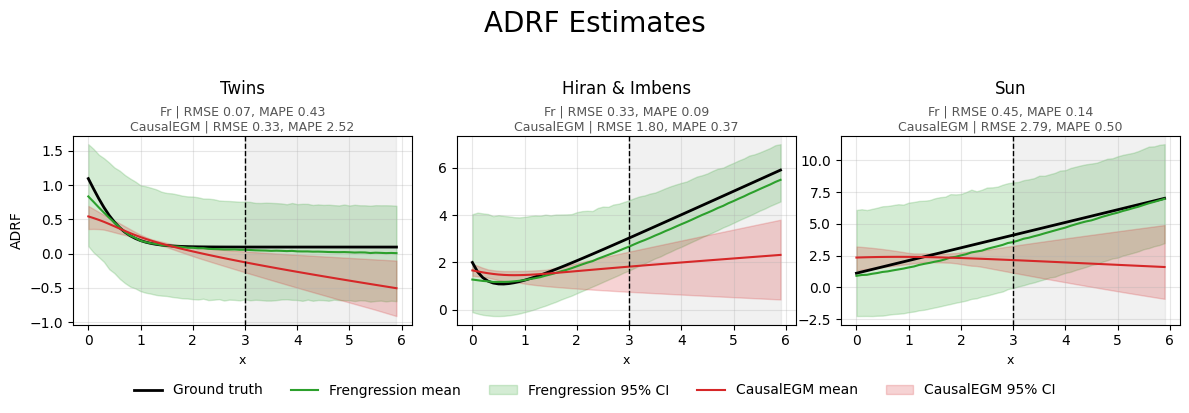

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1) Configuration
dataset_names = ["twins", "hiran","sun"]
pretty_titles = {"twins": "Twins", "hiran": "Hiran & Imbens", "sun": "Sun"}
output_dir    = "result/continuous"

# colors
gt_color    = "k"         # black
fr_color    = "#2ca02c"   # green
egm_color   = "#d62728"   # red
shade_color = "#bbbbbb"   # grey for extrapolated region

# 2) Load summaries
summaries = {}
for name in dataset_names:
    with open(os.path.join(output_dir, f"{name}.json")) as f:
        summaries[name] = json.load(f)

# 3) Make subplots
n = len(dataset_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=False)

for ax, name in zip(axes, dataset_names):
    S      = summaries[name]
    x_vals = np.array(S["x_vals"])
    x_max  = x_vals.max()

    # ground truth ADRF
    if name == "twins":
        gt = Semi_Twins_adrf(x_vals)
    elif name == "hiran":
        gt = Sim_Hirano_Imbens_adrf(x_vals)
    else:
        gt = Sim_Sun_adrf(x_vals)

    # FR predictions
    fr_mu = np.array(S["Frengression"]["mean"])
    fr_lo = np.array(S["Frengression"]["ci_lower"])
    fr_hi = np.array(S["Frengression"]["ci_upper"])
    # EGM predictions
    egm_mu = np.array(S["CausalEGM"]["mean"])
    egm_lo = np.array(S["CausalEGM"]["ci_lower"])
    egm_hi = np.array(S["CausalEGM"]["ci_upper"])

    # metrics
    rmse_fr  = np.sqrt(mean_squared_error(gt, fr_mu))
    mape_fr  = mean_absolute_percentage_error(gt, fr_mu)
    rmse_egm = np.sqrt(mean_squared_error(gt, egm_mu))
    mape_egm = mean_absolute_percentage_error(gt, egm_mu)

    # shade extrapolated region
    ax.axvspan(3, x_max, color=shade_color, alpha=0.2)

    # plot curves & intervals
    ax.plot(x_vals, gt,    color=gt_color, lw=2, label="Ground truth")
    ax.plot(x_vals, fr_mu, color=fr_color, lw=1.5, label="Frengression mean")
    ax.fill_between(x_vals, fr_lo, fr_hi, color=fr_color, alpha=0.2, label="Frengression 95% CI")
    ax.plot(x_vals, egm_mu, color=egm_color, lw=1.5, label="CausalEGM mean")
    ax.fill_between(x_vals, egm_lo, egm_hi, color=egm_color, alpha=0.2, label="CausalEGM 95% CI")

    ax.axvline(3, color=gt_color, linestyle="--", lw=1)

    # — Main title (dataset name) —
    ax.set_title(
        pretty_titles[name],
        fontsize=12,
        pad=30  # give extra room for subtitle
    )

    # — Two‐line subtitle with smaller font —
    subtitle = (
        f"Fr | RMSE {rmse_fr:.2f}, MAPE {mape_fr:.2f}\n"
        f"CausalEGM | RMSE {rmse_egm:.2f}, MAPE {mape_egm:.2f}"
    )
    ax.text(
        0.5, 1.01,            # x=0.5 (center), y=1.02 (just above the top of the axes)
        subtitle,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=9,
        color="#555555"
    )

    ax.set_xlabel("x", fontsize=9)
    ax.grid(alpha=0.3)

axes[0].set_ylabel("ADRF", fontsize=10)

# 4) shared legend below
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=len(handles),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle("ADRF Estimates", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
